In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
current_dir = os. getcwd()
images_dir = os.path.join(current_dir, 'Kirigami_dataset_2_3_400')
image_data = pd.read_csv(os.path.join(images_dir, 'Kirigami_dataset_2_3_400.csv'))

In [4]:
print(image_data.head(3))

      image_name      p1_x      p1_y      p2_x      p2_y      p3_x      p3_y  \
0  image0000.jpg  0.103723  0.300236  0.491135  0.106383  0.875887  0.293144   
1  image0001.jpg  0.103723  0.288416  0.491135  0.089835  0.876773  0.282506   
2  image0002.jpg  0.102837  0.310875  0.490248  0.161939  0.875000  0.289598   

       p4_x      p4_y      p5_x  ...     p12_x     p12_y     p13_x     p13_y  \
0  0.886525  0.615839  0.506206  ...  0.565603  0.742317  0.578901  0.599291   
1  0.878546  0.613475  0.507979  ...  0.567376  0.709220  0.575355  0.586288   
2  0.883865  0.624113  0.509752  ...  0.567376  0.747045  0.576241  0.607565   

      p14_x     p14_y     p15_x     p15_y     p16_x     p16_y  
0  0.583333  0.460993  0.569149  0.323877  0.546986  0.187943  
1  0.579787  0.446809  0.568262  0.309693  0.548759  0.169031  
2  0.579787  0.466903  0.565603  0.332151  0.546986  0.200946  

[3 rows x 33 columns]


In [5]:
image_idx = 1

In [6]:
image_data.iloc[image_idx]['image_name']

'image0001.jpg'

In [7]:
img_arr = cv2.imread(os.path.join(images_dir, image_data.iloc[image_idx]['image_name']))

In [8]:
img_arr.shape

(1944, 2592, 3)

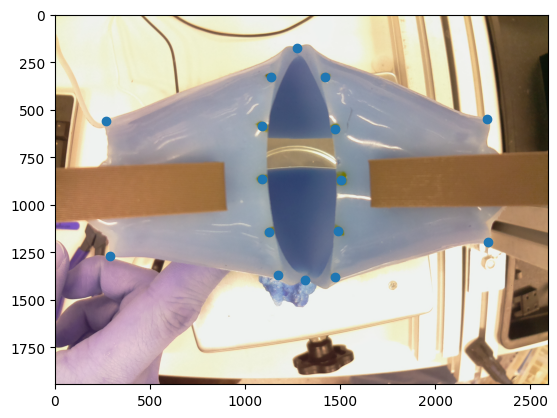

In [9]:
plt.imshow(img_arr)
x_points = image_data.iloc[image_idx][1:][::2]
y_points = image_data.iloc[image_idx][2:][::2]
x_width = img_arr.shape[1]
y_height = img_arr.shape[0]

plt.scatter(x_points*x_width, y_points*y_height)

In [10]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.transform = A.Compose([
            A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1),
            A.RandomBrightnessContrast(brightness_limit=[-0.02, 0.02], contrast_limit=0.3, p=1),
            A.Affine(rotate=random.uniform(-2, 2), p=1),
            A.Affine(translate_percent={'x': random.uniform(-0.04, 0.04), 'y': random.uniform(-0.04, 0.04)}, p=1),
            A.Affine(shear={'x':random.uniform(-2, 2), 'y':random.uniform(-1, 1)}, p=1),
            A.Affine(scale=(0.96,1.02), p=1)
        ], keypoint_params=A.KeypointParams(format='xy'))

        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)
        label = self.df.iloc[idx, 1:]
        image, label = self.transform_image(image, label)
        return image.to(device), torch.tensor(label).to(device)
    
    def __len__(self):
        return self.df.shape[0]
    
    def transform_image(self, image_to_be_transformed, keypoints):
#         x_points = original_df.iloc[i][1:][::2]*image_to_be_transformed.shape[1]
#         y_points = original_df.iloc[i][2:][::2]*image_to_be_transformed.shape[0]
        x_points = keypoints[0:][::2]*image_to_be_transformed.shape[1]
        y_points = keypoints[1:][::2]*image_to_be_transformed.shape[0]
        albumentations_keypoints = list(zip(x_points,y_points))
        
        transformed_keypoints = []
        
#         self.vis_keypoints(image_to_be_transformed, albumentations_keypoints)
        
        while len(transformed_keypoints) != 16:
            transformed = self.transform(image=image_to_be_transformed, keypoints=albumentations_keypoints)
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']

#         self.vis_keypoints(transformed_image, transformed_keypoints)
        
        flatten_coordinates = np.array(transformed_keypoints).flatten()  
        flatten_coordinates[::2] = [x / transformed_image.shape[1] for x in flatten_coordinates[::2]]
        flatten_coordinates[1::2] = [x / transformed_image.shape[0] for x in flatten_coordinates[1::2]]
        
        img = cv2.resize(transformed_image, (224,224))
        img_tensor = transforms.ToTensor()(img)
        img_mean = img_tensor.mean(dim = (1,2))
        img_std = img_tensor.std(dim = (1,2))
        
        img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
        return img_normalised, flatten_coordinates
    
    def load_img(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        img = cv2.imread(img_path)
        return img
    
    
    def vis_keypoints(self, image, keypoints):
        diameter=15
        image = image.copy()

        for (x, y) in keypoints:
            cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)

        plt.figure(figsize=(8, 8))
        plt.axis('off')
        plt.imshow(image)

In [11]:
current_dir = os. getcwd()
images_dir = os.path.join(current_dir, 'Kirigami_dataset_2_3_400')
print(images_dir)

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/Kirigami_dataset_2_3_400


In [12]:
train_df, test_df = train_test_split(image_data, test_size=0.0025)

In [13]:
print(train_df.shape)
print(test_df.shape)

(478, 33)
(2, 33)


In [14]:
train_dataset = ImageDataset(train_df, images_dir)
test_dataset = ImageDataset(test_df, images_dir)

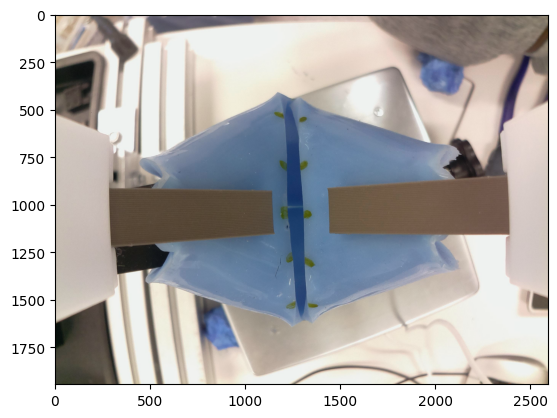

In [15]:
img = test_dataset.load_img(0)
plt.imshow(img)

In [16]:
img_tensor, labels = train_dataset[311]

In [17]:
labels

tensor([0.1321, 0.3024, 0.4984, 0.1595, 0.8482, 0.3356, 0.8460, 0.6449, 0.5063,
        0.7752, 0.1336, 0.6544, 0.4516, 0.2160, 0.4381, 0.3431, 0.4325, 0.4739,
        0.4427, 0.6067, 0.4602, 0.7294, 0.5449, 0.7402, 0.5478, 0.6138, 0.5534,
        0.4807, 0.5449, 0.3503, 0.5380, 0.2235], device='cuda:0',
       dtype=torch.float64)

In [18]:
img_tensor

tensor([[[-1.5320, -1.5320, -1.5320,  ..., -1.5320, -1.5320, -1.5320],
         [-1.5320, -1.5320, -1.5320,  ..., -1.5320, -1.5320, -1.5320],
         [-1.5320, -1.5320, -1.5320,  ..., -1.5320, -1.5320, -1.5320],
         ...,
         [-1.5320, -1.5320, -1.5320,  ..., -1.5320, -1.5320, -1.5320],
         [-1.5320, -1.5320, -1.5320,  ..., -1.5320, -1.5320, -1.5320],
         [-1.5320, -1.5320, -1.5320,  ..., -1.5320, -1.5320, -1.5320]],

        [[-1.7258, -1.7258, -1.7258,  ..., -1.7258, -1.7258, -1.7258],
         [-1.7258, -1.7258, -1.7258,  ..., -1.7258, -1.7258, -1.7258],
         [-1.7258, -1.7258, -1.7258,  ..., -1.7258, -1.7258, -1.7258],
         ...,
         [-1.7258, -1.7258, -1.7258,  ..., -1.7258, -1.7258, -1.7258],
         [-1.7258, -1.7258, -1.7258,  ..., -1.7258, -1.7258, -1.7258],
         [-1.7258, -1.7258, -1.7258,  ..., -1.7258, -1.7258, -1.7258]],

        [[-1.9644, -1.9644, -1.9644,  ..., -1.9644, -1.9644, -1.9644],
         [-1.9644, -1.9644, -1.9644,  ..., -1

In [19]:
img_np = img_tensor.cpu().numpy()
img_np

array([[[-1.5319687, -1.5319687, -1.5319687, ..., -1.5319687,
         -1.5319687, -1.5319687],
        [-1.5319687, -1.5319687, -1.5319687, ..., -1.5319687,
         -1.5319687, -1.5319687],
        [-1.5319687, -1.5319687, -1.5319687, ..., -1.5319687,
         -1.5319687, -1.5319687],
        ...,
        [-1.5319687, -1.5319687, -1.5319687, ..., -1.5319687,
         -1.5319687, -1.5319687],
        [-1.5319687, -1.5319687, -1.5319687, ..., -1.5319687,
         -1.5319687, -1.5319687],
        [-1.5319687, -1.5319687, -1.5319687, ..., -1.5319687,
         -1.5319687, -1.5319687]],

       [[-1.7258452, -1.7258452, -1.7258452, ..., -1.7258452,
         -1.7258452, -1.7258452],
        [-1.7258452, -1.7258452, -1.7258452, ..., -1.7258452,
         -1.7258452, -1.7258452],
        [-1.7258452, -1.7258452, -1.7258452, ..., -1.7258452,
         -1.7258452, -1.7258452],
        ...,
        [-1.7258452, -1.7258452, -1.7258452, ..., -1.7258452,
         -1.7258452, -1.7258452],
        [-1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
(224, 224, 3)


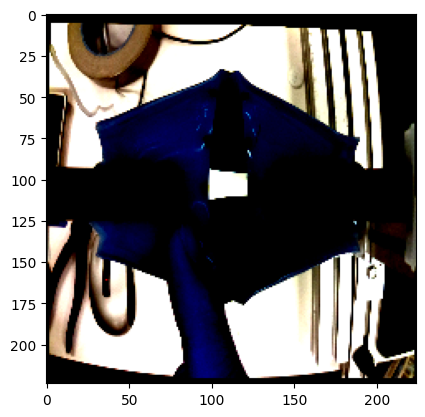

In [20]:
print(img_np.shape)
img_np_reverted = np.transpose(img_np, (1,2,0))
print(img_np_reverted.shape)
plt.imshow(img_np_reverted, clim=(-1, 1))

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [22]:
for img, points in train_dataloader:
  print(img.shape)
  print(points.shape)
  break

torch.Size([8, 3, 224, 224])
torch.Size([8, 32])


In [23]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,50, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(8,8))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3200, 300),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(300, 6),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [24]:
# model = models.vgg16(pretrained=False)
model = VGG_model()

# from torchvision.models import resnet50
# model = resnet50(pretrained=False)

In [25]:
# # making the weights non trainable

# for param in model.parameters():
#   param.requires_grad = False

In [26]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.LeakyReLU(0.1,inplace=True),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.LeakyReLU(0.1,inplace=True),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer

final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.LeakyReLU(0.1,inplace=True),
    nn.Dropout(0.3),
    nn.Linear(300, 32),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [27]:
# model.load_state_dict(torch.load('./Model_2_2000_VGG_Leaky_60_epoch'))

In [28]:
# from torch.nn.modules.activation import Sigmoid
# from torch.nn.modules.pooling import AdaptiveAvgPool2d
# # pool_layer = nn.Sequential(
# #      nn.Conv2d(512,512, kernel_size=3, padding='same'),
# #      nn.ReLU(inplace=True),
# #      nn.MaxPool2d(kernel_size=2, stride=2),
# #      nn.Conv2d(512,50, kernel_size=3, padding='same'),
# #      nn.ReLU(inplace=True),
# #      nn.MaxPool2d(kernel_size=2, stride=2),
# #      nn.AdaptiveAvgPool2d(output_size=(8,8))
# # )

# # model.avgpool = pool_layer

# final_predictor = nn.Sequential(
#     nn.Linear(2048, 300),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.3),
#     nn.Linear(300, 32),
#     nn.Sigmoid()
# )

# model.fc = final_predictor

In [29]:
model = model.to(device)

In [49]:
summary(model, torch.rand(1,3,224,224))

TypeError: rand(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 2

In [31]:
# getting the optimizer and loss_function 

def get_essentials():
  loss_fun = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
  return loss_fun, optimizer

In [32]:
# defining batch_train and accuracy functions


def train_batch(data, model, loss_fun, optimizer):
  model.train()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  loss_val.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss_val.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
  model.eval()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  return loss_val.item()


In [33]:
epochs = 4001
loss_fun, optimizer = get_essentials()

In [34]:
# training and validation loops 


train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
  train_batch_losses, val_batch_losses = [], []
  for data in train_dataloader:
    train_batch_loss = train_batch(data, model, loss_fun, optimizer)
    train_batch_losses.append(train_batch_loss)
  for data in test_dataloader:
    val_batch_loss = val_batch(data, model, loss_fun, optimizer)
    val_batch_losses.append(val_batch_loss)
  train_epoch.append(np.mean(train_batch_losses))
  val_epoch.append(np.mean(val_batch_losses))
  
  with open("Model_2_3_400_output.txt", "a") as f:
    f.write(str([train_batch_loss, val_batch_loss]))
    f.write("\n")
    
  print(train_batch_loss, val_batch_loss)

  if (epoch) % 100 == 0:
    torch.save(model.state_dict(), './Model_2_3_400_VGG_Leaky_' + str(epoch) + '_epoch')

  0%|                                                  | 0/4001 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), './Model_2800_VGG_Leaky_80_epoch')

In [ ]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

# Displaying the results

In [ ]:
def transform_image(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    return img_normalised

In [ ]:
img_path = os.path.join(os.getcwd(), 'Validation_2/image11.jpg')
original_img = cv2.imread(img_path)
test_img = transform_image(original_img)
test_img = test_img.to(device)

Facial_key_points = model(test_img[None]).flatten().detach().cpu()

In [ ]:
# index = 0

plt.subplot(121)
plt.title("Image")
original_img = original_img[:,:,::-1]                                                              
plt.imshow(original_img)
plt.subplot(122)
plt.title(" Image with Keypoints ")
plt.imshow(original_img)

x_points = Facial_key_points.numpy()[0::2]
y_points = Facial_key_points.numpy()[1::2]
plt.scatter(x_points*original_img.shape[1], y_points*original_img.shape[0], s = 2, c=(1,0,0))                       # scaling the keypoints with image dimension
plt.show()

In [ ]:
print(Facial_key_points)

In [ ]:
x_points = Facial_key_points.numpy()[0::2]
y_points = Facial_key_points.numpy()[1::2]
print(x_points)
print(y_points)

# width = img_arr.shape[0]
# height = img_arr.shape[1]

# plt.scatter(x_points*x_width, y_points*y_height)

In [ ]:
for i in range(10):
    
    folder = 'asdsadsd'
    print(folder + str(i).zfill(2)+'.jpg')